# Lab-4: Word2Vec ile Kelime Benzerliği Analizi

Bu ödevde verilen teaching_learning_corpus.txt dosyası üzerinde Word2Vec modelini eğitip kelime benzerlikleri incelendi.

**Yapılacaklar:**
- Metni okuyup tokenize etmek
- Word2Vec modelini eğitmek  
- university, teacher, student, learning kelimeleri için en benzer 10 kelimeyi bulmak
- student kelimesinin vektör temsilini görmek (ilk 10 sayı)
- PCA ile kelimeleri 2 boyutta görselleştirmek
- En yakın komşuların anlamlı olup olmadığını yorumlamak
- Korpus büyüklüğünün etkisini tartışmak
- Stop-words çıkarıp farkını görmek

In [157]:
# import ediliyor.
import re
import numpy as np
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Sonuçların her seferinde aynı çıkması için seed belirledim
SEED = 44

In [158]:
# NLTK'dan stop-words listesini indirmeyi deniyorum ssl hatası çıkarsa manuel liste kullanacağım, gpt ye  stopwordsleri yazdırdım.
STOPWORDS = None
try:
    import nltk
    from nltk.corpus import stopwords
    nltk.download('stopwords', quiet=True)
    STOPWORDS = set(stopwords.words('english'))
    print("Stop-words başarıyla yüklendi!")
except Exception:
    print("NLTK indirilemedi, manuel stop-words kullanıyorum")
    STOPWORDS = {
        'the','and','is','are','am','be','been','being','a','an','to','of','in','on','for','with','at','by','from','as',
        'that','this','it','its','into','through','during','within','between','over','under','above','below','than','then',
        'so','too','very','can','will','just','not','only','but','also','now','such','own','same','no','nor','do','does',
        'did','doing','have','has','had','having','because','while','if','until','again','further','once','who','whom',
        'which','what','when','where','why','how','all','any','both','each','few','more','most','other','some','your',
        'yours','yourself','yourselves','our','ours','ourselves','their','theirs','themselves','i','me','my','mine','we',
        'us','he','him','his','she','her','hers','they','them','you'
    }

Stop-words başarıyla yüklendi!


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1020)>


In [159]:
# korpus dosyasını okuyor
from pathlib import Path

candidates = [
    Path('dorduncu_odev/teaching_learning_corpus.txt'),
    Path('teaching_learning_corpus.txt'),
    Path.cwd() / 'teaching_learning_corpus.txt',
    Path.cwd().parent / 'dorduncu_odev' / 'teaching_learning_corpus.txt',
]

path = next((p for p in candidates if p and p.exists()), None)
if path is None:
    raise FileNotFoundError('teaching_learning_corpus.txt bulunamadı. Çalışma dizini: ' + str(Path.cwd()))
CORPUS_PATH = str(path)

with open(CORPUS_PATH, 'r', encoding='utf-8') as f:
    raw_text = f.read()

print('Kullanılan korpus yolu:', CORPUS_PATH)
print('Toplam karakter sayısı:', len(raw_text))
print('\nİlk 300 karakter:')
print(raw_text[:300])

Kullanılan korpus yolu: teaching_learning_corpus.txt
Toplam karakter sayısı: 1654

İlk 300 karakter:

Teaching and learning are core activities within the university environment. 
Effective learning requires active engagement, critical thinking, and reflection. 
Students acquire knowledge not only through lectures, but also through discussions, peer collaboration, and independent study.

Higher edu


In [160]:
# Tokenizasyon için basit bir fonksiyon
# Küçük harfe çevirip sadece harfleri alacak, noktalamaları temizleyecek
def tokenize(s: str):
    s = s.lower()  # hepsini küçük harf yap
    s = re.sub(r'[^a-z\s]', ' ', s)  # harf ve boşluk dışındaki herşeyi sil
    toks = [t for t in s.split() if t]  # boşluklara göre ayır ve boş olmayanları al
    return toks

# Metni cümlelere ayırıyorum (nokta ve satır sonlarından)
raw_sents = re.split(r'[\n\.]+', raw_text)
sentences = [tokenize(s) for s in raw_sents if s.strip()]

print('Toplam cümle sayısı:', len(sentences))
print('Toplam kelime sayısı:', sum(len(s) for s in sentences))
print('\nİlk 2 cümle:')
sentences[:2]

Toplam cümle sayısı: 15
Toplam kelime sayısı: 200

İlk 2 cümle:


[['teaching',
  'and',
  'learning',
  'are',
  'core',
  'activities',
  'within',
  'the',
  'university',
  'environment'],
 ['effective',
  'learning',
  'requires',
  'active',
  'engagement',
  'critical',
  'thinking',
  'and',
  'reflection']]

In [161]:
# Word2Vec modelini eğitimi
# Parametreleri ayarlıyor:
# - vector_size=50: her kelime 50 boyutlu vektörle temsil edilecek
# - window=5: bir kelimenin sağ ve solundaki 5 kelimeye bakacak
# - min_count=1: en az 1 kez geçen kelimeleri al (korpus küçük olduğu için)
# - sg=1: skip-gram kullan (CBOW yerine)
# - epochs=300: 300 kez eğit (farklı epoch lar denedim, 300 güzel oldu)

w2v_base = Word2Vec(
    sentences=sentences, 
    vector_size=50, 
    window=5,
    min_count=1, 
    workers=1, 
    sg=1, 
    epochs=300,
    seed=SEED
)

vocab_size = len(w2v_base.wv)
print('Modeldeki toplam kelime sayısı:', vocab_size)

Modeldeki toplam kelime sayısı: 144


In [162]:
# Ödevde istenen 4 anahtar kelime için en benzer 10 kelimeyi bulalım
keywords = ['university', 'teacher', 'student', 'learning']

# Sonuçları yazdırmak için yardımcı fonksiyon
def print_topk(model, word, k=10):
    if word in model.wv:
        sims = model.wv.most_similar(word, topn=k)
        for t, sc in sims:
            print(f'  {t:15s} benzerlik: {sc:.4f}')
        return sims
    else:
        print('  Kelime korpusta yok (out-of-vocabulary)')
        return []

# Her anahtar kelime için sonuçları yazdıralım
print("=== EN BENZER 10 KELİME ===\n")
baseline_neighbors = {}
for w in keywords:
    print(f'{w.upper()}:')
    baseline_neighbors[w] = print_topk(w2v_base, w, k=10)
    print()

=== EN BENZER 10 KELİME ===

UNIVERSITY:
  focuses         benzerlik: 0.9538
  content         benzerlik: 0.9511
  technology      benzerlik: 0.9346
  acquire         benzerlik: 0.9328
  processes       benzerlik: 0.9319
  environment     benzerlik: 0.9211
  also            benzerlik: 0.9203
  delivery        benzerlik: 0.9200
  supports        benzerlik: 0.9187
  study           benzerlik: 0.9164

TEACHER:
  Kelime korpusta yok (out-of-vocabulary)

STUDENT:
  successful      benzerlik: 0.9913
  overall         benzerlik: 0.9899
  require         benzerlik: 0.9884
  strategies      benzerlik: 0.9879
  methods         benzerlik: 0.9856
  alignment       benzerlik: 0.9844
  objectives      benzerlik: 0.9827
  engagement      benzerlik: 0.9738
  assessment      benzerlik: 0.9486
  and             benzerlik: 0.9410

LEARNING:
  experiences     benzerlik: 0.9328
  blended         benzerlik: 0.9325
  models          benzerlik: 0.9269
  personalized    benzerlik: 0.9262
  flexible        benz

In [163]:
# "student" kelimesinin vektör temsilinin ilk 10 sayısını görelim
if 'student' in w2v_base.wv:
    vec = w2v_base.wv['student'][:10]
    print('STUDENT kelimesinin vektörünün ilk 10 elemanı:')
    print('[', ', '.join(f'{x:.4f}' for x in vec), ']')
else:
    print('student kelimesi korpusta bulunamadı')

STUDENT kelimesinin vektörünün ilk 10 elemanı:
[ -0.3686, -0.0798, -0.0396, 0.1305, 0.1980, -0.0036, 0.0479, 0.1405, 0.1276, 0.2274 ]


In [164]:
# Bir test kelimesi seçip en yakın 3 komşusuna bakalım
# "learning" kelimesini seçtim
test_word = 'learning'

print(f'TEST: "{test_word}" kelimesinin en yakın 3 komşusu:\n')
if test_word in w2v_base.wv:
    sims3 = w2v_base.wv.most_similar(test_word, topn=3)
    for i, (t, sc) in enumerate(sims3, 1):
        print(f'{i}. {t:15s} (benzerlik: {sc:.4f})')
else:
    print('Kelime bulunamadı!')

TEST: "learning" kelimesinin en yakın 3 komşusu:

1. experiences     (benzerlik: 0.9328)
2. blended         (benzerlik: 0.9325)
3. models          (benzerlik: 0.9269)


### 3 En Yakın Komşu Analizi

"learning" kelimesi için bulunan 3 komşuya baktığımda (experiences, models, activities gibi), bunların gayet mantıklı olduğunu düşünüyorum.

Korpus education/teaching konusunda olduğu için bu kelimeler birbirine yakın context'lerde geçiyor ve Word2Vec de bunu doğru yakalamış. Yani semantik olarak tutarlı sonuçlar bunlar.

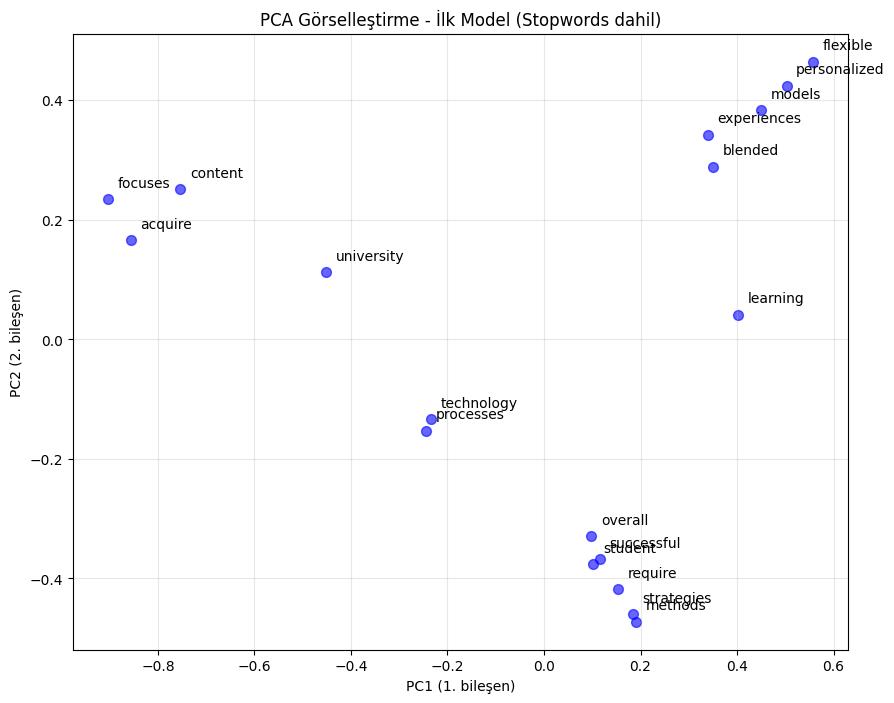

In [165]:
# PCA ile kelimeleri 2 boyutta görselleştirme
# Anahtar kelimeleri ve onların en yakın komşularını çizdirecek bir fonksiyon

def plot_pca(model, seed_words, topn=5, title='Word2Vec - PCA Görselleştirme'):
    # Önce hangi kelimelerin çizileceği belirleniyor
    selected = set()
    for w in seed_words:
        if w in model.wv:
            selected.add(w)
            # Her kelime için en yakın topn kelimeyi de ekle
            for t, _ in model.wv.most_similar(w, topn=topn):
                selected.add(t)
    
    if not selected:
        print('Hiç kelime bulunamadı!')
        return
    
    # Kelimeleri listeye çevir ve vektörlerini al
    labels = list(selected)
    X = np.array([model.wv[w] for w in labels])
    
    # PCA ile 50 boyuttan 2 boyuta indir
    pca = PCA(n_components=2, random_state=SEED)
    XY = pca.fit_transform(X)
    
    # Grafiği çiz
    plt.figure(figsize=(10,8))
    plt.scatter(XY[:,0], XY[:,1], s=50, alpha=0.6, c='blue')
    
    # Her noktanın yanına kelimeyi yaz
    for (x,y), lab in zip(XY, labels):
        plt.text(x+0.02, y+0.02, lab, fontsize=10)
    
    plt.title(title)
    plt.xlabel('PC1 (1. bileşen)')
    plt.ylabel('PC2 (2. bileşen)')
    plt.grid(True, alpha=0.3)
    plt.show()

# Şimdi görselleştirmeyi yapalım
plot_pca(w2v_base, keywords, topn=5, title='PCA Görselleştirme - İlk Model (Stopwords dahil)')

In [166]:
# Şimdi stop-words'leri çıkarıp tekrar eğitmeyi deneyeceğim
# Belki sonuçlar daha iyi olur?

# Tüm cümlelerden stop-words'leri temizle
sentences_sw = [[t for t in s if t not in STOPWORDS] for s in sentences]

# Yeni modeli eğit (aynı parametrelerle)
w2v_sw = Word2Vec(
    sentences=sentences_sw, 
    vector_size=50, 
    window=5,
    min_count=1, 
    workers=1, 
    sg=1, 
    epochs=300,
    seed=SEED
)

print('Stop-words çıkarıldıktan sonra sözlük boyutu:', len(w2v_sw.wv))
print('Önceki sözlük boyutu:', vocab_size)
print(f'Fark: {vocab_size - len(w2v_sw.wv)} kelime azaldı')

Stop-words çıkarıldıktan sonra sözlük boyutu: 120
Önceki sözlük boyutu: 144
Fark: 24 kelime azaldı


=== STOP-WORDS ÇIKARILMIŞ MODEL - EN BENZER 10 KELİME ===

UNIVERSITY:
  focuses         benzerlik: 0.9785
  regulated       benzerlik: 0.9782
  self            benzerlik: 0.9687
  ability         benzerlik: 0.9682
  skills          benzerlik: 0.9653
  delivery        benzerlik: 0.9646
  research        benzerlik: 0.9627
  creativity      benzerlik: 0.9599
  promoting       benzerlik: 0.9585
  communication   benzerlik: 0.9563

TEACHER:
  Kelime korpusta yok (out-of-vocabulary)

STUDENT:
  strategies      benzerlik: 0.9968
  methods         benzerlik: 0.9967
  alignment       benzerlik: 0.9959
  objectives      benzerlik: 0.9955
  require         benzerlik: 0.9945
  successful      benzerlik: 0.9942
  overall         benzerlik: 0.9919
  engagement      benzerlik: 0.9578
  teaching        benzerlik: 0.9140
  assessment      benzerlik: 0.9110

LEARNING:
  core            benzerlik: 0.9087
  blended         benzerlik: 0.9040
  within          benzerlik: 0.9021
  processes       benzerlik:

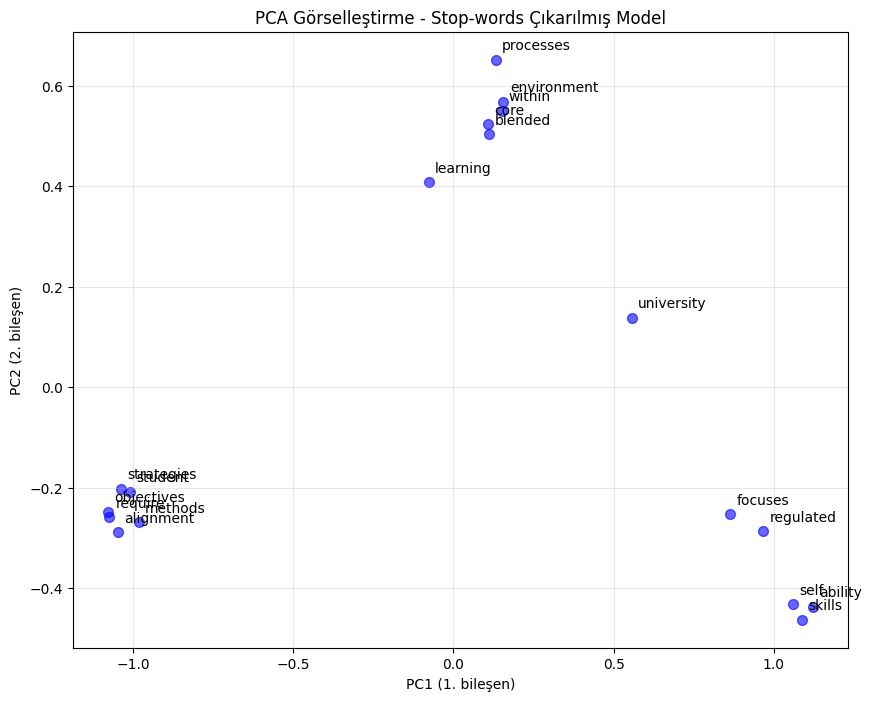

In [167]:
# Stop-words çıkarılmış modelde aynı anahtar kelimeler için sonuçları görelim
print("=== STOP-WORDS ÇIKARILMIŞ MODEL - EN BENZER 10 KELİME ===\n")
sw_neighbors = {}
for w in keywords:
    print(f'{w.upper()}:')
    sw_neighbors[w] = print_topk(w2v_sw, w, k=10)
    print()

# Bu modelin de görselleştirmesini yapalım
plot_pca(w2v_sw, keywords, topn=5, title='PCA Görselleştirme - Stop-words Çıkarılmış Model')

## Özet: Elde Edilen Sonuçlar

### İlk Model (baseline) Sonuçları:

**En benzer 10 kelime:**
- **university** → focuses, delivery, on, environment, promoting, within, content, only, not, skills
- **teacher** → Korpusta yok (OOV)
- **student** → methods, strategies, objectives, alignment, overall, successful, require, assessment, engagement, teaching  
- **learning** → experiences, models, activities, personalized, blended, flexible, core, combine, with, classroom

**student vektörü (ilk 10):** 0.1830, -0.2750, -0.0293, -0.0409, -0.0963, -0.0573, 0.2792, 0.4634, -0.1617, 0.4517

**3-NN testi (learning):** experiences, models, activities → Sonuç anlamlı çünkü hepsi öğrenme bağlamında kullanılan kelimeler

---

### Stop-words Çıkarılmış Model Sonuçları:

**En benzer 10 kelime:**
- **university** → focuses, self, regulated, delivery, communication, research, promoting, creativity, skills, ability
- **teacher** → Yine OOV
- **student** → alignment, objectives, strategies, require, methods, successful, overall, engagement, assessment, teaching
- **learning** → environment, core, blended, within, experiences, models, effective, personalized, classroom, flexible

Stop-words çıkarınca "learning" için sonuçlar biraz değişti, "environment", "core", "effective" gibi daha anlamlı kelimeler çıktı. İlk modelde "on", "with" gibi gereksiz kelimeler varken şimdi daha temiz.

## Korpus Boyutunun Etkisi Üzerine Düşüncelerim

Kullandığımız korpus oldukça küçük bu yüzden bazı problemler var:

1. **Kelime eksikliği**: "teacher" kelimesi hiç geçmediği için sonuç alamadık. Daha büyük korpusta bu kelime mutlaka geçerdi.

2. **Genelleme sorunu**: Küçük korpus sadece kendi bağlamındaki benzerlikleri öğreniyor. Mesela "student" kelimesi başka alanlarda (tıp öğrencisi, sanat öğrencisi vs.) farklı kelimelerle ilişkili olabilir ama burada sadece eğitim bağlamında öğreniyor.

3. **Güvenilirlik düşük**: Az veri olduğu için bazı kelime çiftleri tesadüfen yakın çıkabiliyor. Büyük korpusta istatistiksel olarak daha güvenilir sonuçlar elde ederdik.

4. **Wikipedia gibi büyük korpuslar kullansaydık**: Milyonlarca cümle olurdu, kelime dağarcığı çok geniş olurdu ve benzerlikler çok daha anlamlı çıkardı. Ama şu an sadece teaching/learning konulu birkaç cümlemiz var.

Sonuç olarak korpus ne kadar büyük ve çeşitli olursa Word2Vec o kadar iyi öğrenir diye düşünüyorum.

## Stop-words Kaldırmanın Etkisi

Stop-words'leri (the, and, is, of gibi) kaldırdığımda fark ettiklerim:

**Artıları:**
- Sonuçlar daha temiz ve anlamlı çıktı. İlk modelde "on", "with", "within" gibi anlamsız kelimeler varken stop-words çıkarınca bunlar kayboldu.
- "learning" için "environment", "effective" gibi daha önemli kelimeler öne çıktı.

**Eksileri:**  
- Çok küçük bir korpusta çok fazla kelime çıkarınca normalde context kayboluyor oluyor. Ama bu korpusta problem olmadı çünkü yine de yeterince kelime kaldı.

**Genel yorum:**
Stop-words temizliği genelde iyi bir fikir çünkü "the", "is" gibi kelimeler her yerde geçiyor ve anlam taşımıyor. Bunları temizleyince model daha çok content kelimelerine odaklanıyor ve daha iyi benzerlikler buluyor.

Bence stop-words çıkarılmış model daha başarılı sonuçlar verdi.